# Welcome!

We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    print("Ipython")
    #!pip install IPython
    from IPython import display
else:
    print("pyvirtualdisplay")
    #!pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()
ion_context = plt.ion()

#import lunar_PPO_utils
#!pip install JSAnimation
from lunar_PPO_utils import *
from parallelEnv import parallelEnv #X as parallelEnv
from surrogate_fxns import clipped_surrogate
print("Using device", device, "imported from PPO_utils.")

Ipython
Using device cuda:0 imported from PPO_utils.


In [2]:
#!pip install JSAnimation
#from lunar_PPO_utils import *
#print("Using device", device, "imported from PPO_utils.")
#from parallelEnv import parallelEnv #X as parallelEnv
#from surrogate_fxns import clipped_surrogate
#from lunar_PPO_utils import collect_trajectories
# widget bar to display progress
#!pip install progressbar
#import progressbar as pb

In [3]:
#import gymnasium as gym
SEED=1234
env = gym.make("LunarLander-v2", render_mode="rgb_array") #,  #"human",
                                 #continuous= True,
                                 #gravity= -9.81,
                                 #enable_wind= True,
                                 #wind_power= 3.14,
                                 #turbulence_power= 0.1)

state, info = env.reset(seed = SEED)
state_shape = env.observation_space.shape
state_size = state_shape[0]
action_size = env.action_space.n
print('State shape: ', state_size)
print('Number of actions: ', action_size, "\n")

for i in range(13):
    action = env.action_space.sample()  
    state, reward, done, trun, info = env.step(action)

print(action, done or trun)
print(np.round(reward, 3))
print(np.round(env.step(2)[0], 3)) 

State shape:  8
Number of actions:  4 

1 False
1.544
[ 0.086  1.498  0.593  0.186 -0.018  0.052  0.     0.   ]


In [4]:
# run your own policy!
policy=VectorPolicy().to(device)

# Solution policy:
#policy=lunar_PPO_utils.Policy().to(device)

# Start with the adam optimizer with learning rate 2e-4
# TO DO consider optim.SGD with learning rate 1e-4
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=2e-4)

In [5]:
#
print(np.round(env.step(0)[0], 3), SEED)   #

[ 0.092  1.501  0.593  0.16  -0.015  0.052  0.     0.   ] 1234


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



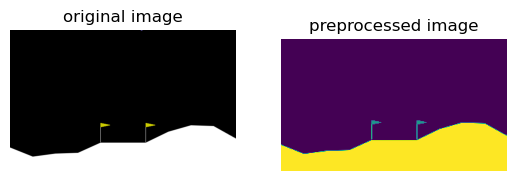

In [6]:
# show what a preprocessed image looks like
env.reset()
_, _, _, _, _ = env.step(2)
# get a frame after 20 steps
for _ in range(17):
    _, _, _, _, _ = env.step(0)
    frame = env.render()

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.axis('off')
plt.title('preprocessed image')
# 80 x 80 black and white image
plt.imshow(prep_frame(frame))#, cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
**Policy input**:
* $P_{\rm up}$, the probability of moving out. Note that $P_{\rm left}= 1-P_{\rm down}$

**Policy output**:
* A tuple of floats representing thrust to main and lateral engines, respectively.
* In (-1,1)
* **TO DO** clip these per game settings: (main>=0, lateral<-0.5 or lateral>0.5)



# Game Configuration


If continuous=True is passed, continuous actions (corresponding to the throttle of the engines) will be used and the action space will be Box(-1, +1, (2,), dtype=np.float32). The first coordinate of an action determines the throttle of the main engine, while the second coordinate specifies the throttle of the lateral boosters. Given an action np.array([main, lateral]), the main engine will be turned off completely if main < 0 and the throttle scales affinely from 50% to 100% for 0 <= main <= 1 (in particular, the main engine doesn’t work with less than 50% power). Similarly, if -0.5 < lateral < 0.5, the lateral boosters will not fire at all. If lateral < -0.5, the left booster will fire, and if lateral > 0.5, the right booster will fire. Again, the throttle scales affinely from 50% to 100% between -1 and -0.5 (and 0.5 and 1, respectively).





## Specs

*Observation Space*

The **state** is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

*Rewards*

After every step a reward is calculated based on state and action values at that step: this is the ***reward function*** the network will try to approximate with these step values and its learned expection of the reward values for future states and actions following from that step (indirectly through weight adjustment, but **TO DO** *maybe also eg. an RMM-like feed-forward link too?*).

For each step, the **step reward**:

* is increased/decreased the closer/further the lander is to the landing pad.

* is increased/decreased the slower/faster the lander is moving.

* is decreased the more the lander is tilted (angle not horizontal).

* is increased by 10 points for each leg that is in contact with the ground.

* is decreased by 0.03 points each frame a side engine is firing.

* is decreased by 0.3 points each frame the main engine is firing.

The **total reward** of an episode is the sum of the all the step-rewards accumulated for that episode. The episode receives an final additional reward of -100 or +100 points for crashing or landing safely, respectively. An episode is considered **a solution** if it scores at least 200 points on average over 100 episodes.

**Starting State**
> The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

**Episode Termination**
> The episode finishes if:
  * the lander crashes (the lander body is in contact with the moon)
  * the lander remains outside of the viewport (x coordinate is greater than 1)

# Game Play

In [7]:
#play(env, policy, time=200) 

# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [8]:
discount=0.88 #1-1/4
rewards=np.random.rand(64)
discount = discount**np.arange(64)
#rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
#rewards_future.shape
np.round(discount, 3), rewards[::-1].cumsum(axis=0).shape#[::-1]

(array([1.   , 0.88 , 0.774, 0.681, 0.6  , 0.528, 0.464, 0.409, 0.36 ,
        0.316, 0.279, 0.245, 0.216, 0.19 , 0.167, 0.147, 0.129, 0.114,
        0.1  , 0.088, 0.078, 0.068, 0.06 , 0.053, 0.047, 0.041, 0.036,
        0.032, 0.028, 0.025, 0.022, 0.019, 0.017, 0.015, 0.013, 0.011,
        0.01 , 0.009, 0.008, 0.007, 0.006, 0.005, 0.005, 0.004, 0.004,
        0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001,
        0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.   , 0.   , 0.   ,
        0.   ]),
 (64,))

# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [33]:
def train(policy, envs, episodes, tmax=1000, SGD_epoch=3, gamma=0.999, epsilon=0.995, beta=0.999):

    # keep track of progress
    mean_rewards = []

    # keep track of how long training takes
    #widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
    #timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()

    for e in range(episodes):

        # collect trajectories returns **lists** of arrays:
        # latest version: prob_list, state_list, action_list, reward_list
        old_probs, states, actions, rewards = collect_trajectories(envs, policy, tmax=tmax, skip=11)

        total_returns = np.sum(rewards, axis=0)
        # get the average reward of the parallel environments
        mean_returns = np.mean(rewards, axis=0)
        mean_rewards.append(mean_returns)

        # stochastic gradient Ascent step
        for _ in range(SGD_epoch):

            # Loss is surrogate function ratio, R
            # made negative because ascent delta is in the _opposite direction_ of loss
            # clipped to given limits to avoid "reward cliff" run-away estimation
            L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)
            optimizer.zero_grad()
            L.backward()
            optimizer.step()
            del L

        # the clipping parameter reduces over time
        epsilon = max(epsilon*epsilon, 0.005)  #.999

        # the regulation term also reduces to decrease exploration after many runs
        beta = max(beta*beta, 0.005) #.995
          
        #scores_window.append(score)       # save most recent score
        #scores.append(score)              # save most recent score
        #episode_lengths.append(episteps)
        #eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        #cycle_steps = agent.steps%BUFFER_SIZE
        #buffer_cycle = agent.steps//BUFFER_SIZE

        print("\rEpisode {:4d} | Average: {:7.2f} | Total: {:7.2f} | Epsilon: {:1.3f} | Beta: {:1.3f} |".format(e, 
                                                                                                                mean_returns,
                                                                                                                total_returns,
                                                                                                                epsilon,
                                                                                                                beta), end="")
                                                                                                                                        
        if e % 100 == 0:
            #chkpntname = "data/chkpnt{}.pth".format(e)
            #torch.save(agent.qnetwork_local.state_dict(), chkpntname)   
            print("\rEpisode {:4d} | Average: {:7.2f} | Total: {:7.2f} | Epsilon: {:1.3f} | Beta: {:1.3f} |".format(e, 
                                                                                                                    mean_returns,
                                                                                                                    total_returns,
                                                                                                                    epsilon,
                                                                                                                    beta))
        
        if mean_returns>=200. and FIRST:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:5.2f}'.format(e-100, mean_rewards))
            #torch.save(agent.qnetwork_local.state_dict(), 'data/slvdpnt.pth')
            FIRST = False
        elif mean_returns>=250. :
            print("\n***** High Score! *****")
            print("\tGame over.")
            #torch.save(agent.qnetwork_local.state_dict(), 'data/hipnt.pth')
            break
            
        # update progress widget bar
        #timer.update(e+1)

    #timer.finish()
    return mean_rewards

In [34]:
old_probs, states, actions, rewards = collect_trajectories(envs, policy, tmax=tmax, skip=11)
clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)



tensor(0.5018, device='cuda:0')

In [35]:
# Hyperparameter Control 
n_parallel_agents=5
envs = parallelEnv("LunarLander-v2", n=n_parallel_agents, seed=1234)
discount_rate = 0.999#1 - 1/(n_parallel_agents+1)
epsilon = 0.995  # 0.05 no decay...?
beta = 0.999     # .01 
tmax = 1000    # training loop max = 1000
SGD_epoch = 2  #
# WARNING: running through all 800 episodes will take 30-45 minutes
episodes = 200  #800
SEED=1234
mean_rewards = train(policy, envs, episodes, tmax, SGD_epoch, gamma=discount_rate, epsilon=epsilon, beta=beta)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [10]:
n_parallel_agents=5
envs = parallelEnv("LunarLander-v2", n=n_parallel_agents, seed=1234)
discount = 0.999 #1 - 1/(n_parallel_agents+1)
epsilon = 0.995  # 0.05 no decay...?
beta = 0.999     # .01 
tmax = 1000      # training loop max = 1000
SGD_epoch = 4    #
# WARNING: running through all 800 episodes will take 30-45 minutes
episodes = 200  #800
SEED=1234

states = envs.reset()
states = np.asarray(states)
mean = np.mean(states, axis=1)
std = np.std(states, axis=1) + 1.0e-8
norm_states = (states - mean[:, np.newaxis])/std[:, np.newaxis]
norm_states, scale_input_batch(states)

(array([[-0.1823007 ,  2.438727  , -1.270335  , -0.5617797 , -0.15886863,
          0.07746112, -0.1714521 , -0.1714521 ],
        [-0.4596616 ,  2.4700966 , -0.79966253,  0.5325886 , -0.45232955,
         -0.37848827, -0.45627156, -0.45627156],
        [-0.29874447,  2.568453  , -0.05204507, -0.95356935, -0.3040415 ,
         -0.35764307, -0.30120468, -0.30120468],
        [-0.5566876 ,  2.456928  ,  0.16145879,  0.36627325, -0.57213247,
         -0.72814196, -0.563849  , -0.563849  ],
        [-0.17464083,  2.4991915 , -0.77636415, -1.0182447 , -0.16167633,
         -0.03098305, -0.16864128, -0.16864128]], dtype=float32),
 array([[0.49805182, 0.9687297 , 0.44079956, 0.47897178, 0.5010789 ,
         0.5134098 , 0.        , 0.        ],
        [0.499451  , 0.97390985, 0.4833169 , 0.5480422 , 0.5003048 ,
         0.503779  , 0.        , 0.        ],
        [0.50040114, 0.9679134 , 0.5121881 , 0.4680885 , 0.49977913,
         0.49723923, 0.        , 0.        ],
        [0.5011227 , 0.

In [27]:
states = envs.reset()
states = np.asarray(states)
shog = states.shape
np.reshape(states, (*shog,1)).shape

(5, 8, 1)

In [11]:
states_to_sigs(policy, scale_input_batch(states)), states_to_probs(policy, scale_input_batch(states)), states_to_pols(policy, scale_input_batch(states))

(tensor([[0.4766, 0.4665, 0.5042, 0.4897],
         [0.4772, 0.4672, 0.5039, 0.4900],
         [0.4773, 0.4668, 0.5037, 0.4902],
         [0.4777, 0.4675, 0.5036, 0.4901],
         [0.4768, 0.4665, 0.5040, 0.4899]], device='cuda:0'),
 tensor([[0.2421, 0.2325, 0.2703, 0.2551],
         [0.2424, 0.2328, 0.2697, 0.2551],
         [0.2425, 0.2325, 0.2695, 0.2554],
         [0.2427, 0.2330, 0.2693, 0.2550],
         [0.2423, 0.2324, 0.2700, 0.2553]], device='cuda:0'),
 tensor([[-0.0936, -0.1342,  0.0167, -0.0410],
         [-0.0912, -0.1316,  0.0157, -0.0400],
         [-0.0908, -0.1331,  0.0147, -0.0391],
         [-0.0894, -0.1302,  0.0145, -0.0397],
         [-0.0927, -0.1343,  0.0159, -0.0403]], device='cuda:0'))

In [28]:
########## CLIPPED from surrogate_fxns
#del clipped_surrogate from surrogate_fxns import clipped_surrogate

discount = 0.999
epsilon = 0.995
beta = 0.99
n_parallel_agents=5
envs = parallelEnv("LunarLander-v2", n=n_parallel_agents, seed=1234)

### CT returns **lists**
old_sigs, states, actions, rewards = collect_trajectories(envs, policy, tmax=1000, skip=11)

# convert everything into pytorch tensors and move to gpu if available
#actions = np.asarray(actions, dtype=np.int8)
#actions = torch.tensor(actions, dtype=torch.int8, device=lpu.device)

#### convert rewards to normed future rewards
rewards = np.asarray(rewards)
print("rewards _________________\n\t", rewards.shape)
gamma = discount**np.arange(len(rewards))
print("gamma ___________________\n\t", gamma.shape)
gamma = gamma[:,np.newaxis]
print("gamma new axis __________\n\t", gamma.shape)
rewards = rewards*gamma
print("rewards gamma ________\n\t", rewards.shape)
rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
print("\nrewards_future ___________\n\t", rewards_future.shape)

mean = np.mean(rewards_future, axis=1)
print("\nrews mean ____________\n\t", mean.shape)
mean = mean[:, np.newaxis]
print("rews mean newaxis ____\n\t", mean.shape)
std = np.std(rewards_future, axis=1) + 1.0e-8
print("rews std _____________\n\t", std.shape)
std = std[:, np.newaxis]
print("rews std newaxis _____\n\t", std.shape)
rewards_normalized = (rewards_future - mean)/std
print("rewards normed _________\n", rewards.shape)
print("would_be rewards _______\n", rewards[:,:, np.newaxis].shape)
rewards = torch.tensor(rewards_normalized, dtype=torch.float32, device=lpu.device)
print("rewards tensor _________\n", rewards.shape)

##### Pre-Norm States
states = np.asarray(states, dtype=np.float32)
shog = states.shape
print("states ___________________\n", states.shape)
states = lpu.scale_input_batch( states.reshape(-1, 8) )
print("states scaled ___________\n", states.shape)
states = states.reshape(*shog)
print("states reshaped ___________\n", states.shape)
states = torch.tensor(states, dtype=torch.float32, device=lpu.device) 
print("states tensor ___________\n", states.shape)
# convert states to policy (or probability)
new_sigs = states_to_sigs(policy, states)
print("new_sigs _________________\n", new_sigs.shape)
old_sigs = np.asarray(old_sigs, dtype=np.float32)
old_sigs = torch.tensor(old_sigs, dtype=torch.float32, device=lpu.device)
print("old_sigs __________________\n", old_sigs.shape)
# ratio for clipping
ratio = new_sigs/old_sigs
print("ratio ___________________\n", ratio.shape)
# clipped function
clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
print("clip ___________________\n", clip.shape)
try:
    rxr = ratio*rewards
    cxr = clip*rewards
except:
    print(">>> The problem is here.")
    print("ratio ___________________\n", ratio.shape)
    print("rewards ___________________\n", rewards.shape)
    print("clip ___________________\n", clip.shape)
    rewards = rewards.view(-1, rewards.shape[1], 1)
    print(">>> Solution:\nrewards new view ________\n", rewards.shape)

rxr = ratio*rewards
cxr = clip*rewards
print("R x R, C X R ___________________\n", rxr.shape, cxr.shape)

try:
    clipped_surge = torch.min(rxr, cxr)
    print("clipped surrogate__________\n>>> ", clipped_surge.shape)
except:
    print("clipped surrogate__________\n>>> Well that didn't work! <<<")

# include a regularization term to steer new_policy towards 0.5
try:
    entropy = -1*( new_sigs*torch.log(old_sigs+1.e-10) + (1.0-new_sigs)*torch.log(1.0-old_sigs+1.e-10) )
    print("entropy ___________________\n", entropy.shape)

except:
    print("entropy ___________________\n>>> Problem. <<<")

# returns an average of all the entries of the tensor
# effective computing L_sur^clip / T averaged over time-step and number of trajectories
try:
    rtrnval = torch.mean(clipped_surge + beta*entropy, axis=-1)
    print("\nreturn:{}".format(rtrnval.shape))
except:
    print("\nAnd that's it.")

#############################################


rewards _________________
	 (80, 5)
gamma ___________________
	 (80,)
gamma new axis __________
	 (80, 1)
rewards gamma ________
	 (80, 5)

rewards_future ___________
	 (80, 5)

rews mean ____________
	 (80,)
rews mean newaxis ____
	 (80, 1)
rews std _____________
	 (80,)
rews std newaxis _____
	 (80, 1)
rewards normed _________
 (80, 5)
would_be rewards _______
 (80, 5, 1)
rewards tensor _________
 torch.Size([80, 5])
states ___________________
 (80, 5, 8)
states scaled ___________
 (400, 8)
states reshaped ___________
 (80, 5, 8)
states tensor ___________
 torch.Size([80, 5, 8])
new_sigs _________________
 torch.Size([80, 5, 4])
old_sigs __________________
 torch.Size([80, 5, 4])
ratio ___________________
 torch.Size([80, 5, 4])
clip ___________________
 torch.Size([80, 5, 4])
>>> The problem is here.
ratio ___________________
 torch.Size([80, 5, 4])
rewards ___________________
 torch.Size([80, 5])
clip ___________________
 torch.Size([80, 5, 4])
>>> Solution:
rewards new view ______

In [31]:
old_sigs, states, actions, rewards = collect_trajectories(envs, policy, tmax=1000, skip=11)

clipped_surrogate(policy, old_sigs, states, actions, rewards)

tensor(-0.0327, device='cuda:0')

In [13]:
states, rewards, dones, infos = envs.step([envs.action_space.sample()]*5)
print("states, rewards, dones, infos, shapes:\n{}\n{}\n{}\n{}\n{}".format(np.round(states,3), np.round(rewards, 3), dones, infos,
                                                                         [x.shape for x in [states, rewards, dones]]+[len(infos)])) 

states, rewards, dones, infos, shapes:
[[-0.194  1.882 -0.805  0.951  0.414  0.108  0.     0.   ]
 [ 0.607  1.598  1.258  0.9   -0.099  0.032  0.     0.   ]
 [ 0.014  1.394  0.728 -0.4   -0.019 -0.209  0.     0.   ]
 [-0.213  2.565 -0.509  1.25   0.167  0.004  0.     0.   ]
 [-0.295  1.948 -0.457  1.151  0.015 -0.063  0.     0.   ]]
[-0.411 -1.521 -2.369 -0.146  0.416]
[False False False False False]
({}, {}, {}, {}, {})
[(5, 8), (5,), (5,), 5]


In [32]:
mean_rewards = train(policy, envs, episodes, tmax, SGD_epoch, gamma=discount_rate, epsilon=epsilon, beta=beta)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
plt.plot(mean_rewards)

In [ ]:
# save your policy!
torch.save(policy, 'lunar_PPO.policy')

# load policy if needed
#policy = torch.load('PPO.policy')
#pong_utils.play(env, policy, time=1000) 

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO version can win more often than not)!
#
#policy_solution = torch.load('PPO_solution.policy')
#pong_utils.play(env, policy_solution, time=1000) 